# Ön Bilgi
**Geliştiren :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesinin İçeriği :** 3 farklı sınıfa ait toplamda 3000 tweet bulunmaktadır.

**Tweet Sınıfları :** 

-	Olumlu Tweetler
-	Olumsuz Tweetler
-	Nötr Tweetler

**Veri Kümesi Referansı :** "Eğiticili ve Geleneksel Terim Ağırlıklandırma Yöntemleriyle Duygu Analizi", Mahmut Çetin, M.Fatih Amasyalı, SIU 2013, KKTC

**Algoritma :** Decision Tree (DT)

**Ağ Mimarisi :** 


**batch_size :** 

**epochs :** 

**Doğruluk Oranı :** %100


---



In [1]:
import pandas as pd                     
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
tweets = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Sets/milliyet.csv", sep=';', encoding="ISO-8859–9")
tweets = tweets.drop(['ItemID'], axis=1)
tweets

,Sentiment,SentimentText
0,1,başka dünyanın çocukları 1 ocak sabahından be...
1,1,hepsi nin kızları yerli sevmez mi heygir...
2,1,2009 da ülkemizdeki sağlık harcamaları ve alın...
3,1,laktozsuz sütü kimler içmeli bir bardak süt ...
4,1,2009 trendleri ve içimizdeki alışveriş canavar...
...,...,...
8995,9,h l mı eğer h l bu memlekette kadın erkek ...
8996,9,aşk böceği özellikle haziran ve temmuz ayla...
8997,9,akp karavanı anayasa değişikliği ne getiriyor...
8998,9,boncuk bulma bizim apartmanın içerden ve dış...


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silme İşlemi : 

In [3]:
tweets.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [4]:
tweets = tweets.dropna().reset_index(drop=True)
tweets.isnull().sum()

Sentiment        0
SentimentText    0
dtype: int64

### Gereksiz Kelimeleri - Boşukları - İşaretleri Silme İşlemleri :  

In [5]:
nltk.download('stopwords')
stop_word_list = stopwords.words('turkish')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [6]:
def preprocess_text(sen):
    
    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sen))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [7]:
x = tweets['SentimentText']
y = tweets['Sentiment']

In [8]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,SentimentText
0,başka dünyanın çocukları ocak sabahından beri ...
1,nin kızları yerli sevmez mi heygirl dergisinin...
2,ülkemizdeki sağlık harcamaları alınması gereke...
3,laktozsuz sütü kimler içmeli bir bardak süt iç...
4,trendleri içimizdeki alışveriş canavarı yurtdı...
...,...
8995,memlekette kadın erkek eşitliği tartışılıyorsa...
8996,aşk böceği özellikle haziran temmuz aylarının ...
8997,akp karavanı anayasa değişikliği getiriyor çoc...
8998,boncuk bulma bizim apartmanın içerden dışardan...


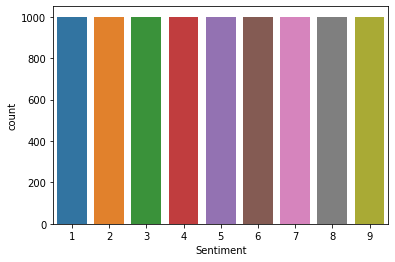

In [9]:
sns.countplot(y)

## Kelimeleri Sayılara Dönüştürelim : 

Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.


In [10]:
token = Tokenizer()
# Her kelimenin sıklığını hesaplar
token.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = token.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

In [11]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
3776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,87713,9670,268,7227,36200,2510,11702,6909,72488,22759,2880,9274,99,67,23,2146,459,186,9670,149,38,4449,57,1547,19659,34813,469,13739,30,680,1261,529,16853,7317,99,805,115,305,13913,4141
3964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18,990,15882,74,71246,1424,175285,2841,2874,2740,15882,10711,18,549,2932,93,568,2399,1315,311,1773,11356,507,174,52252,88,201,15,1,2335,2412,34834,51291,855,14895,1266,702,1413,2412,88010
2220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1524,5329,155919,1718,26374,1075,289,46,700,247,124,37,256,6838,87,359,191,8126,15256,97858,99,2052,289,221,1350,13,16211,292,10600,595,1013,2820,2055,5,4420,77843,155920,17626,30345,70246
331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,558,248,4913,1029,65686,14789,2984,867,4,2888,558,248,14,3314,15979,752,336,7344,905,28461,65687,51026,18137,136,150,4021,3914,3984,46138,586,525,375,130,1,485,9904,46139,33,53,1663
7717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2023,4660,174,7,114,59,10,2020,193,399,222600,1612,7765,3553,21062,184,3055,17212,32883,1680,186,49468,2274,2659,255,137,1262,2190,65,540,462,4232,160,80582,529,4720,13368,773,4480,13


## X Verilerimizi Ölçeklendirelim : 

**Verileri Ölçeklendirme Nedir?**

Ölçeklendirme dediğimiz şey veri setindeki iki farklı özelliğin (değişkenin) değerlerini en doğru şekilde analiz edebilmemize olanak sağlayan bir yöntemdir.

- Verilerinizin dağılımının ortalama değeri 0 ve standart sapma değeri 1 olacak şekilde değiştiriyoruz (Standartlaştırma).
- Tutarlılık oluşuyor. Bir veri diğer verilerden daha büyükse diğerleri üzerinde egemenlik kurabilir. Bunu istemeyiz.
- Bir öğrenme modeliyle çalışırken, özellikleri sıfır merkezli bir aralığa ölçeklemek önemlidir.
- Değerleri karşılaştırmak yerine oranları karşılaştırmış oluruz.

**Örnek :**

İki farklı insan düşünelim. Bu insanların birisinin geliri ayda 5.000 Türk Lirası iken diğerinin geliri ayda 200.000 Türk Lirası olsun. Bu insanların ikisi de her ay belirli miktarda maddi yardım için maaşlarının bir kısmını ayırıyorlar. Diyelim ki 5.000 Türk Lirası maaşı olan şahıs 1.500 Türk Lirasını yardıma ayırıyorken, 200.000 Türk Lirası alan şahıs 10.000 Türk Lirasını yardım için ayırıyor.

Normal bir gözle bakarsak 10.000 Türk Lirası yardımda bulunan kişinin daha fazla yardım yaptığını görürüz. Fakat bunu oranladığımızda 5.000 Türk Lirası alan kişinin oransal olarak kat kat fazla yardım yaptığı anlaşılacaktır. İşte özellik ölçeklendirme ile biz bu özelliklerin sayısal değerlerinin birbirine yakın olmasını sağlayıp aralarındaki değerleri karşılaştırmak yerine oranları karşılaştırırız.

In [12]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [13]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
5105,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.128456,-0.116344,-0.058712,-0.436402,-0.422987,-0.392743,-0.161503,-0.422920,-0.419597,-0.447403,-0.285663,-0.058500,0.241674,0.395639,-0.407665,-0.312767,4.664721,-0.438017,-0.353905,-0.094139,-0.365255,-0.375607,-0.186820,-0.342175,-0.219039,-0.429725,-0.260379,-0.340474,-0.345385,-0.380802,-0.428825,-0.453566,-0.427832,-0.403999,-0.449142,-0.442014,-0.365174,-0.443550,-0.420037,-0.517043
862,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.216238,-0.435960,-0.268293,-0.339665,-0.426909,-0.037916,-0.363217,-0.442361,-0.415524,-0.449112,-0.421030,-0.413196,-0.359230,3.318335,-0.420753,0.064831,0.874789,-0.426826,-0.012197,-0.439889,-0.418985,-0.330944,3.456533,-0.425992,0.301644,-0.384844,-0.396245,1.612222,-0.429713,0.180793,-0.407396,-0.371332,-0.217494,-0.228955,2.014392,0.185553,2.133581,-0.379127,-0.393075,-0.271993
5181,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.435706,1.813930,-0.246925,-0.145604,-0.415118,-0.286327,-0.053757,-0.157929,-0.076615,-0.195297,-0.298675,-0.129445,-0.301792,-0.223220,-0.430644,-0.434696,-0.435725,-0.441695,-0.143473,-0.309948,-0.231812,-0.434992,0.885359,1.516195,2.696684,-0.435983,-0.420811,-0.442877,4.540284,-0.429150,-0.433843,0.600540,0.452822,-0.433378,-0.172991,0.068614,-0.427106,-0.352140,0.192375,-0.517043
7824,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.412629,-0.407818,1.005014,-0.438559,-0.427231,-0.435709,-0.302251,-0.139222,-0.446074,0.257387,-0.367018,-0.314817,-0.405671,-0.433767,5.189296,-0.442361,-0.196140,-0.441984,-0.028753,-0.391732,-0.002371,2.554943,-0.415788,5.731946,2.291633,-0.405181,-0.440633,-0.431128,-0.292147,-0.426015,-0.428105,-0.368371,-0.138550,-0.412077,-0.400032,-0.397890,-0.444855,-0.447474,-0.384566,-0.479323
2849,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,0.805429,-0.372795,-0.246899,3.911731,-0.132603,-0.359455,-0.413734,-

# Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  


---


**One Hot Encoding Nedir?**

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem, ağın model için problemi daha kolay hale getirmesine yardımcı olabilir. 


- Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir.
- Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışındaki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [14]:
pd.DataFrame(y).sample(5)

,Sentiment
832,1
6189,7
5414,6
8373,9
8199,9


In [15]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
267,0
5665,5
3334,3
8760,8
5975,5


In [16]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2,3,4,5,6,7,8
4366,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3038,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5238,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6799,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
898,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train ve Test İşlemleri İçin Ayrımı Gerçekleştirelim : 

---


In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [18]:
print('x Train : ' + str(x_train.shape))
print('x Test : ' + str(x_test.shape))
print('y Train : ' + str(y_train.shape))
print('y Test : ' + str(y_test.shape))

x Train : (7200, 3560)
x Test : (1800, 3560)
y Train : (7200, 9)
y Test : (1800, 9)


In [19]:
pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3520,3521,3522,3523,3524,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559
6863,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.436560,-0.436955,-0.364011,-0.428869,-0.428574,-0.439402,0.594402,-0.444064,-0.444249,-0.383214,-0.240912,-0.244929,2.128940,-0.438255,-0.431097,-0.377767,5.187768,2.830098,-0.224574,-0.429796,-0.229037,-0.437181,-0.404064,-0.442562,-0.434622,-0.329391,-0.088952,-0.442877,0.164235,2.613404,2.872048,-0.436948,0.666276,-0.443643,-0.444725,-0.448746,-0.441449,-0.222606,-0.242158,-0.102469
3980,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,2.516159,2.485094,-0.382790,-0.436003,-0.253381,-0.172122,-0.434119,0.994916,-0.421766,-0.449112,-0.444181,-0.351794,0.401321,-0.010075,-0.437314,-0.438082,-0.254608,-0.423937,-0.450869,-0.429872,-0.440015,-0.226459,1.957593,-0.329471,-0.447916,-0.422955,-0.440046,1.564637,0.247745,-0.430142,-0.261150,-0.433694,-0.447860,-0.117199,-0.428215,0.491710,0.716222,-0.433637,0.699756,3.257541
3699,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.435008,-0.437734,-0.282397,-0.438399,-0.431850,4.197160,-0.199188,0.318264,-0.131447,-0.440538,-0.252785,1.520687,-0.279231,0.522513,-0.312904,-0.407613,-0.388267,0.632642,4.136396,-0.259178,-0.442219,0.332531,-0.262880,0.636265,4.063391,-0.372060,0.247959,3.971607,-0.433723,1.824282,1.183502,0.237115,-0.089764,-0.260830,2.033453,0.016222,0.751107,0.358831,-0.419202,-0.478031
2915,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,-0.361222,-0.413597,-0.336700,-0.398389,1.874173,-0.386032,-0.434958,3.858046,-0.349107,0.232465,-0.445371,-0.442717,-0.421142,-0.334819,-0.335128,-0.083641,0.131120,-0.273046,0.782474,-0.427057,-0.443905,1.096195,-0.073030,1.724372,-0.409530,2.527233,-0.413158,-0.441492,2.373872,-0.389657,-0.411666,-0.321026,-0.397984,-0.431243,-0.441597,-0.164318,-0.437658,-0.384682,3.847638,-0.484511
7042,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,-0.010542,...,0.002454,-0.408248,-0.422751,0.015049,-0.418717,-0.342393,-0.273013,0.450943,-0.445545,

In [20]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)


# Katmanları Oluşturup Eğitime Başlayalım : 

---


In [22]:
model = Sequential()

model.add(Embedding(1000, 20, input_length=3560))
model.add(Conv1D(64, 3, activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

history = model.fit(x_train,y_train,batch_size=32,epochs=10,verbose=1,validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3560, 20)          20000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3558, 64)          3904      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2313      
_________________________________________________________________
activation_2 (Activation)    (None, 9)                

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - 33s 5ms/step - loss: 0.3641 - acc: 0.8862 - val_loss: 0.2970 - val_acc: 0.8898
Epoch 2/10
7200/7200 [==============================] - 32s 4ms/step - loss: 0.2672 - acc: 0.8926 - val_loss: 0.2523 - val_acc: 0.8953
Epoch 3/10
7200/7200 [==============================] - 31s 4ms/step - loss: 0.2481 - acc: 0.8957 - val_loss: 0.2407 - val_acc: 0.8967
Epoch 4/10
7200/7200 [==============================] - 32s 4ms/step - loss: 0.2402 - acc: 0.8979 - val_loss: 0.2342 - val_acc: 0.9020
Epoch 5/10
7200/7200 [==============================] - 32s 4ms/step - loss: 0.2331 - acc: 0.9008 - val_loss: 0.2285 - val_acc: 0.9017
Epoch 6/10
7200/7200 [==============================] - 32s 4ms/step - loss: 0.2290 - acc: 0.9020 - val_loss: 0.2283 - val_acc: 0.9043
Epoch 7/10
7200/7200 [==============================] - 32s 4ms/step - loss: 0.2262 - acc: 0.9035 - val_loss: 0.2232 - val_acc: 0.9062
Epoch 8

In [23]:
score = model.evaluate(x_test, y_test, verbose = 0)

In [24]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.21961247629589506
Test accuracy: 0.9055558443069458


# Sonuçları Değerlendirelim

---


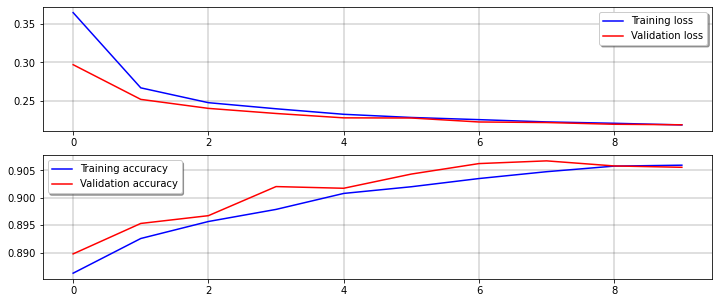

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

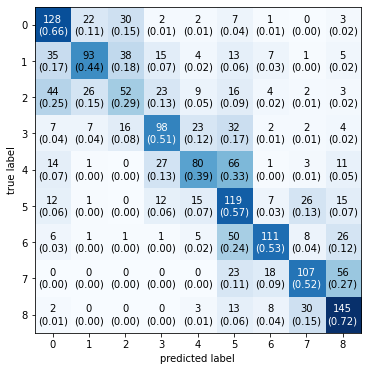

In [26]:
y_pred = model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat = cm,
                                show_normed = True,
                                figsize = (6,6))